# Uniform Random Sampling
Abhilash Reddy M, Originally written sometime in 2016. updated on May 29 2022

This notebook describe methods for uniformly random sampling over some common shapes. This is a python notebook that can be found [here](https://github.com/AbhilashReddyM/notebooks/blob/main/random_sampling/Random%20Sampling.ipynb).  Use the table of contents below to jump to a particular section.

#### Contents
1. [Line](#line)
2. [Triangle](#triangle)
3. [Square](#square)
3. [Parallellogram](#parallellogram)
4. [Polygon](#polygon)
4. [Circle](#circleproper):
    - [Naive wrong method](#circlenaive)
    - [Correct methods](#circleproper)
5. [Surface of sphere](#surfsphereproper)
    - [Naive wrong method](#surfspherewrong)
    - [Correct methods](#surfsphereproper)

We start with a small amount of boiler plate code to import NumPy and Matplotlib modules. We are using two distributions functions from numpy here: uniform and standard_normal. If your programming language does not come with a standard normal distribution function, you can make use of the Box-Muller transform to generate standard normal distributed samples from a uniform distribution. So, just a uniform random generator is sufficient to use any of the methods described. In `C` one finds `u=(double)rand()/RAND_MAX;` as a means of generating uniform random samples. A caveat: It is not exactly a uniform distribution, but it should be more than enough for most cases. `C++` 2011 introduced the `random` header that has more random number generators.

In [29]:
#set up the notebook and the environment
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style() # set the style of plots to match the notebook theme
import numpy as np
from numpy.random import uniform,standard_normal
import matplotlib.pyplot as plt

## Uniform sampling on a line <a name="line"></a>
I will assume that we have access to a 1D uniform distribution sampling function and a 1D normal distribution sampling function. So, uniform sampling on a line becomes trivial by mapping the line to $[0,1)$. Then uniformly random draws from $[0,1)$ can be mapped back to the line.

## Uniform sampling in a Triangle <a name="triangle"></a>
We plot a triangle to begin with and then generate $N=1000$ uniformly distributed random points inside it. 

$P = (1 - \sqrt{r_1}) A + (\sqrt{r_1} (1 - r_2))  B + (r_2 \sqrt{r_1}) C$ where $r_1, r_2 \sim U[0, 1)$ gives us the required sampling. [Refs: [1](https://math.stackexchange.com/questions/18686/uniform-random-point-in-triangle), [2 (pdf)](https://www.cs.princeton.edu/~funk/tog02.pdf), [3](#osada)]

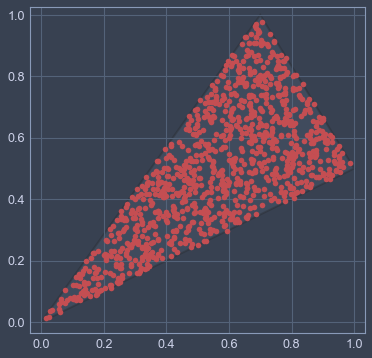

In [30]:
N=1000
verts=np.asarray([[0,0],[0.7,1],[1,0.5]])
fig,ax=plt.subplots(figsize=[6,6])
_=ax.add_artist(plt.Polygon(verts,alpha=0.3,lw=2,ec='k'))

p1 = np.sqrt(uniform(0,1,N)) # taking sqrt here itself
p2 = uniform(0,1,N)

ts=np.empty([N,2])
ts[:,0] = (1-p1)*verts[0,0] + p1*(1-p2)*verts[1,0] + p2*p1*verts[2,0]
ts[:,1] = (1-p1)*verts[0,1] + p1*(1-p2)*verts[1,1] + p2*p1*verts[2,1]
_=ax.plot(ts[:,0],ts[:,1],'ro')

This works for any triangle. Change the `verts` in the above block and re-run the block to see it. 

An alternative solution is to form a parallellogram using any two sides of the triangle. And generate random points in the parallellogram (as shown below). Some points will fall outside the main triangle and in the second triangle. These points can be `folded` back, across the third edge, on to the main triangle and used as a uniform sample.

## Uniform sampling in a Square <a name="square"></a>

This is pretty straightforward. Each point is made of two independent random draws. This works for rectangles and cubes and cuboids just as well.

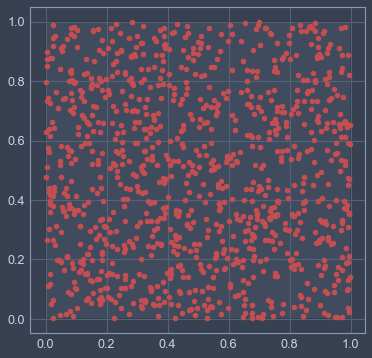

In [31]:
N=1000
verts=np.asarray([[0,0],[0,1],[1,1],[1,0]])
fig,ax=plt.subplots(figsize=[6,6])
_=ax.add_artist(plt.Polygon(verts,alpha=0.3,lw=2,ec='k'))

u1 = uniform(0,1,N)
u2 = uniform(0,1,N)

_=ax.plot(u1,u2,'ro')

## General parallellogram <a name="parallellogram"></a>
For a general square that is not aligned with the coordinate axis, we could calculate a transformation that maps it to a reference unit square. We can then sample the points on the reference geometry and use the inverse transformation to get the distribution on the actual geometry. However, there is an easier way shown below that works for any arbitrary parallellogram. Any point inside a parallellogram can be written in terms of the two edge vectors that form the parallellogram. This will not work for a general quadrilateral, which will be dealt with further down. 

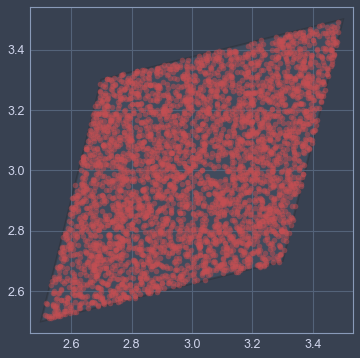

In [59]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, aspect='equal', autoscale_on=True)

verts=2.5+np.asarray([[0,0],[0.2,0.8],[1,1],[0.8,0.2]])
_=ax.add_artist(plt.Polygon(verts,alpha=0.3,lw=2,ec='k'))

N=4000
u1 = uniform(0,1,N)
u2 = uniform(0,1,N)

e1= verts[1]-verts[0]
e2= verts[3]-verts[0]

p=verts[0] +  u1[:,np.newaxis]*e1+ u2[:,np.newaxis]*e2
_=ax.plot(p[:,0],p[:,1],'ro', alpha=0.5 , mfc='r', mec='none')

## General Polygon <a name="polygon"></a>

#### Method 1
We can use the triangle sampler from above to generate points uniformly inside a polygon in the following way:
1. Decompose the polygon into triangles
2. Find the areas of the triangles
3. Choose a triangle with probability proportional to its area (important!)
4. Generate a random uniform point on the chosen triangle

#### Method 2
We can make use of the general rejection sampling method. 
1. Find the bounding box for your polygon
2. Generate uniformly random points within this bounding box.
3. Discard any points not within the polygon

This is a very general method. The following demonstrates this with a general polygon. There is one additional task here: testing if a point is inside a polygon. There are multiple ways to check this. If the polygon is convex, there is a very fast test that can be used:

In [33]:
def pinp_c(p,q):
    """
    Determine if point p is inside convex polygon q
    Returns True if p is inside q, False otherwise
    we loop over all edges of q and check if p is on the same side of all the edges
    If yes, then p is inside q
    Input:
          p: point to be tested, array of size 2
          q: vertices of convex polygon, Nx2 array, have to be ordered CW or CCW
    """
    d=np.cross(np.roll(q,-1,axis=0)-q,p-q)
    return np.all(d>0) or np.all(d<0)

The following function uses a ray casting method and works for compex polygons including non-convex polygons, polygons with holes, and inverted polygons (based on an algorithm in [Paul Bourke's site](http://paulbourke.net/geometry/polygonmesh/) attributed to [Dr. Randolph Franklin](https://scholar.google.com/citations?user=YFX36Q8AAAAJ&hl=en))

In [34]:
def pinp_nc(p,q):
    """
    Determine if point p is inside general non-convex polygon q
    Returns True if p is inside q, False otherwise
    This uses the ray casting method. based on a Paul Bourke article
    """
    c=False
    j=len(q)-1
    for i in range(len(q)):
        t1=(q[i,1]<=p[1] and p[1]<q[j,1]) or (q[j,1]<=p[1] and p[1]<q[i,1])
        t2=p[0]<(q[j,0]-q[i,0])*(p[1]-q[i,1])/(q[j,1]-q[i,1])+q[i,0]
        if t1 and t2:
            c=not c
        j=i
    return c

Following code shows generation of points in arbitrary polygons using rejection based on the function `pinp_nc`. Try changing the polygon defnition and the test function to `pinp_nc` and see what happens. There are other methods like the winding number method or the angle subtended method also which might be used. 

If you can guarantee that the polygon will be convex then the convex-only test should be used because it is very fast.

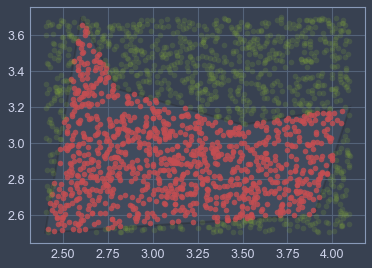

In [58]:
fig,ax=plt.subplots(figsize=[6,6])
ax.set_aspect('equal')

poly=2.5 + np.asarray([[-0.1,0],[1.4,0.1],[1.6,0.7], [1.0,0.6] ,[0.3,0.8], [0.1,1.2]])
_=ax.add_artist(plt.Polygon(poly,alpha=0.3,lw=2,ec='k'))
bbox=np.array([poly.min(axis=0),poly.max(axis=0)])

N=1000
ns=0
while ns<N:
    u1=uniform()
    u2=uniform()
    p=bbox[0]+np.array([u1*(bbox[1,0]-bbox[0,0]),u2*(bbox[1,1]-bbox[0,1])])
    if pinp_nc(p,poly):
        ns+=1
        _=ax.plot(p[0],p[1],'ro', alpha=0.8, mec='none')
    else:
        _=ax.plot(p[0],p[1],'go', alpha=0.2, mec='none')

Finally, if a lot of points are needed inside a large complicated polygon (imagine the boundary of a meshed region), it will be faster to use an auxiliary background grid and use a distance function based method to test the points. 

## Uniform sampling inside a circle <a name="circlenaive"></a>

Now, we move on to sampling inside circles. in a disk. in the 2-d ball. First a naive implementation based on the polar parametrization of the circle is demonstrated to produce wrong distribution. Then, several procedures that generate proper samples are described.
## Naive [WRONG] procedure
We want to generate $N$ random points inside the circle, such that they are distributed with an equal density.  Using polar coordinates, $r$ and $\theta$, any point inside a circle or radius $r_0$ can be represented as

$$(x,y)=(r~cos(\theta),r~sin(\theta))$$
for 
$$r\in[0,r_0),~\theta\in[0,2\pi) $$

The naive approach is to randomly pick $N$ values each of $r\in[0,r_0]$ and a $\theta\in[0,2\pi]$ and calculate $x$ and $y$. As we shall see this does not give us a uniform distribution inside the circle. Lets say $N=1000$ and $r_0=2$.

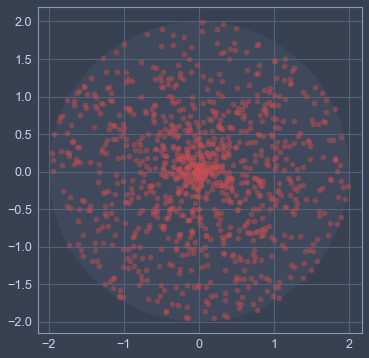

In [36]:
r0 = 2.0
N  = 1000

r  = r0*uniform(0,1,N)
t  = uniform(0,2*np.pi,N)

x,y= r*np.cos(t),r*np.sin(t)

fig,ax=plt.subplots(figsize=(6,6))
ax.add_artist(plt.Circle((0, 0), r0,alpha=0.25))
ax.plot(x,y,'ro', alpha=0.5, mec='none')
ax.set_aspect('equal')

Clearly, we do not get a uniform distribution of points in the cirle this way. The points are clustered near the center. Lets take a step back and see why this went wrong. Lets say we already have a uniform sampling inside the circle, then on integrating the point density over $\theta$ we would find the the density along $r$ is not constant (i.e not uniform). In fact, the density at any $r$ would be proportional to the value of $r$ at that point. This means drawing $r$ from a uniform distribution was not right.

## \[Correct\] Circle Sampling <a name="circleproper"></a>
 We need to draw $r$ from a distribution that starts at 0 and increases linearly till $r=r_0$. We can use the **Inverse transform sampling** procedure to draw from the correct distribution. For this to work, we need to integrate the $PDF$ to get the $CDF$ and then invert the $CDF$. Applying the inverse of the $CDF$ on a uniformly sampled random variable will give us draws from the $PDF$ that we need. Given a continuous uniform variable $ U$ in $ [0,1)$ and an invertible cumulative distribution function $F_{X}$, the random variable $X=F_{X}^{-1}(U)$ has distribution $F_{X}$.[[wikipedia page](https://en.wikipedia.org/wiki/Inverse_transform_sampling)].

In this particular case the correct distributions are $PDF(r)=2r$ and $CDF=r^2$ and so $CDF^{-1}(x)=x^{\frac{1}{2}}$. So, for the radius we draw uniform samples again but this time instead of using it directly, we take square-root. Alternative way to think about this is to imagine that we are taking uniform samples for $r^2$ from $[0,r_0^2]$.

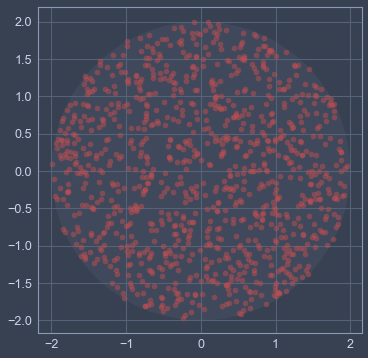

In [37]:
r  = r0*np.sqrt(uniform(0,1,N))
t  = uniform(0,2*np.pi,N)
#################################
x,y= r*np.cos(t),r*np.sin(t)
fig,ax=plt.subplots(figsize=(6,6))
ax.add_artist(plt.Circle((0, 0), r0,alpha=0.25))
ax.plot(x,y,'ro', alpha=0.5, mec='none')
ax.set_aspect('equal')

This looks uniform now. In my opinion, this is the most elegant method. It needed $2N$ samples total. This is not necessarily the most efficient method. Rejection sampling is probably going to be competitive in low dimensions.

## Alternative procedure 1
There is an alternative way to sample the "linear" probability distribution, without going the inverse transform sampling route. This needs two independent draws from a uniform distribution for the radius (i.e. three draws total). First, we add the two draws. The resulting points look like they have been drawn from a distribution that looks like a hat function with a peak at $r_0$ and domain from $0$ to $2r_0$. 'Folding back' the portion in $[r_0,2r_0]$ onto $[0,r_0]$, we get our linearly increasing distribution.
(Somewhat related: [Central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem))

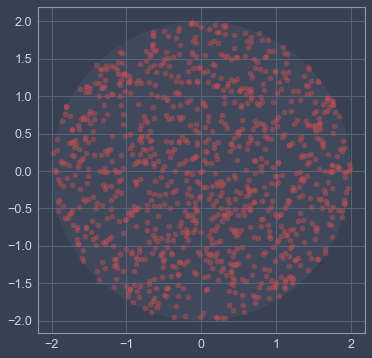

In [38]:
x1 = uniform(0.0,r0,N)
x2 = uniform(0.0,r0,N)
r  = x1+x2
r  = r0-np.abs(r-r0) # same as r=2*r0-r if r>r0 else r

########################################
x,y= r*np.cos(t),r*np.sin(t)
fig,ax=plt.subplots(figsize=(6,6))
ax.add_artist(plt.Circle((0, 0), r0,alpha=0.25))
ax.plot(x,y,'ro', alpha=0.5, mec='none')
ax.set_aspect('equal')

This looks alright as well. We needed to draw $3N$ samples.

## Alternate procedure 2: Rejection Sampling
First, uniform samples in the square region $[-r_0,r_0]\times[-r_0,r_0]$ are drawn. Then, only the samples that fall inside the circle are kept. This is repeated until we have the necessary number of samples. 

Total number of samples drawn: 2568


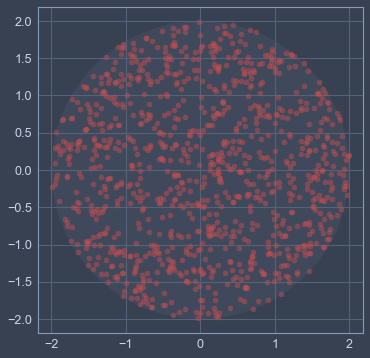

In [39]:
x=[]
y=[]
r0square=r0**2
ns=0
k=0
while(ns<N):
    k+=1  
    xp = uniform(-r0,r0,1)
    yp = uniform(-r0,r0,1)
    if (xp**2+yp**2) < r0square:#acceptable
        x.append(xp)
        y.append(yp)
        ns+=1
    
########################################
fig,ax=plt.subplots(figsize=(6,6))
ax.add_artist(plt.Circle((0, 0), r0,alpha=0.25))
ax.plot(x,y,'ro', alpha=0.5, mec='none')
ax.set_aspect('equal')
print('Total number of samples drawn:',2*k)

Unlike the previous methods, number of draws needed for this method is not known apriori. This is very simple to program easily extendable to 3D and different shapes like ellipses and ellipsoids for instance.

## Sampling on the surface of a sphere <a name="surfspherewrong"></a>
Sampling 'on a circle' is trivial. We can draw from a uniform distribution in $[0,2\pi)$. This is the same as generating random directions or randomly oriented vectors in 2D world. The same in 3D  is less clear. Generating a uniform sampling on the surface of a sphere is the same as generating uniformly randomly oriented vectors in 3D space. (Note: This is different from randomly rotating a 3D object. A vector does not change when rotated about itself, whereas a general 3D object would). Again, I start with a incorrect naive implementation based on the spherical coordinate parametrization and then show methods that generate the correct distribution.

### Naive [WRONG] method
The surface of a sphere can be parametrized in $\theta$ and $\phi$. Lets see what we get when we naively sample these two from a uniform distribution. We'll take it to be a unit sphere.

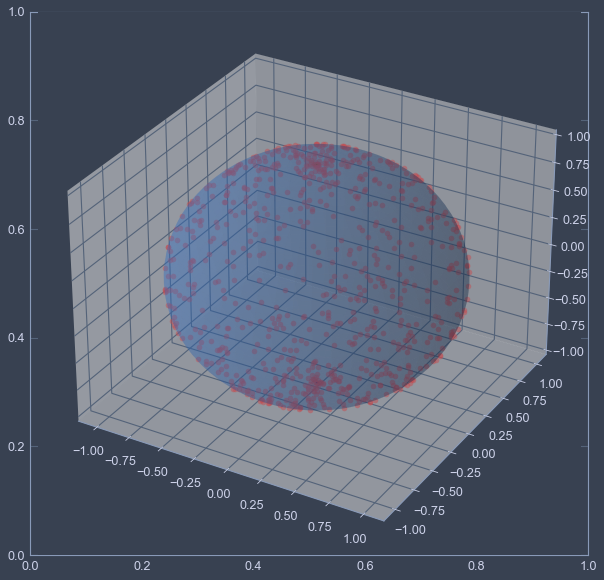

In [40]:
N=800
phi   = np.random.uniform(0,2*np.pi,size=N)
theta = np.random.uniform(0,2*np.pi,size=N)

st=np.sin(theta)
ct=np.cos(theta)
sp=np.sin(phi)
cp=np.cos(phi)

v=np.c_[st*cp,st*sp,ct]

fig,ax=plt.subplots(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot(v[:,0],v[:,1],v[:,2],'ro', alpha=0.5, mec='none')
# ax.set_aspect('equal')

# Make spherical surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x =  np.outer(np.cos(u), np.sin(v))
y =  np.outer(np.sin(u), np.sin(v))
z =  np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
collection=ax.plot_surface(x, y, z,alpha=0.25)


It is perhaps a little hard to make out but you should see points clustering at the poles. There are more points at the north and south poles that at the equator. This is similar to the problem seen in the earlier section with the naive sampling in the circle. To address this issue we can again do a inverse transform sampling of $\theta$ as shown in the next section. Notice that there is no problem in the $\phi$ direction. So $\phi$ was okay to be drawn from a uniform distribution.


### Correct method (Inverse transform sampling) <a name='surfsphereproper'></a>
When a hollow sphere is sliced along the latitudes(i.e. with equidistant parallel planes), the surface area of the slice (referring to surface area of a sliced *hollow sphere* and not the "cross-section" area of a sliced solid sphere) does not depend on the latitude. This means that $\phi\in[0,2\pi)$ can be picked uniformly. Applying the arc cosine function to uniformly drawn samples from $[-1,1]$ to give the right spread for $\theta$.

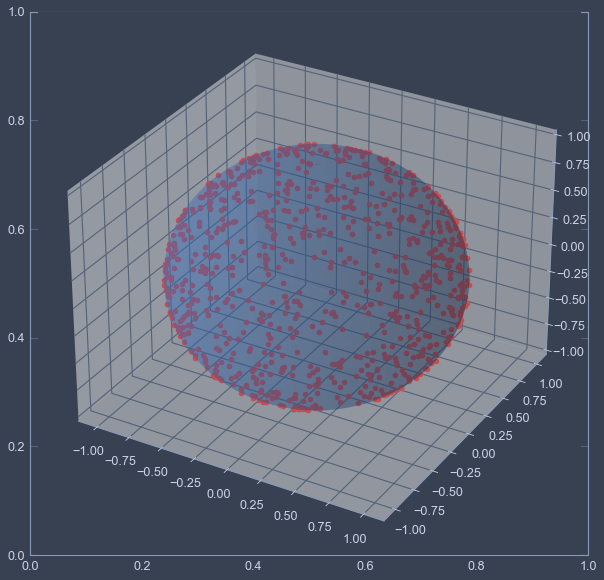

In [41]:
N=800
phi   = uniform(0,2*np.pi,size=N)
theta = np.arccos(uniform(-1,1,size=N))

st=np.sin(theta)
ct=np.cos(theta)
sp=np.sin(phi)
cp=np.cos(phi)

pts=np.c_[st*cp,st*sp,ct]

fig,ax=plt.subplots(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot(pts[:,0],pts[:,1],pts[:,2],'ro')

# For Visualization, make spherical surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x =  np.outer(np.cos(u), np.sin(v))
y =  np.outer(np.sin(u), np.sin(v))
z =  np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
collection=ax.plot_surface(x, y, z,alpha=0.25)

### Alternate method 1: Using normal distribution
This is an intriguing method and its not immediately apparent why it works. I will first demonstrate it in 2D i.e. sampling on a circle for illustration (of course, sampling on a circle is just uniformly sampling from $[0,2\pi)$). 

For sampling on a circle, we generate (x,y) pairs independently from a standard normal distribution. Lets first see what that gives us.

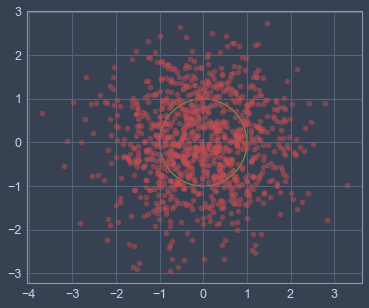

In [42]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, aspect='equal', autoscale_on=True)

N=1000
pts=standard_normal(size=[N,2])
ax.add_artist(plt.Circle((0, 0), 1.0,fc='none', ec='g',lw=1.0 ))
_=ax.plot(pts[:,0],pts[:,1],'ro', alpha=0.5, mec='none')


We notice that the distribution of the points is isotropic. It exhibits radial symmetry. This phenomenon makes the sampling procedure possible. Since they are radially symmetric, normalizing the points will cause them to lie on the boundary of the circle and be uniformly randomly distrubuted, as shown by the next code block.

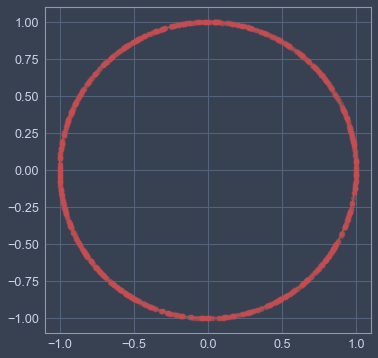

In [43]:
pts/=np.sqrt(np.sum(pts**2,axis=-1)[:,np.newaxis])
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, aspect='equal', autoscale_on=True)
ax.add_artist(plt.Circle((0, 0), 1.0,alpha=0.8, fc='none', ec='g', lw=1.0))
_=ax.plot(pts[:,0],pts[:,1],'ro', alpha=0.5, mec='none')

The extension to sampling on spherical surfaces is routine. In fact, this method generalizes to arbitrary dimensions. It is perhaps not the most efficient method in low dimensions but I like the generality.

For surface of sphere, we first get points(in 3D space) by independently drawing the x,y,z coordinates for each point from a normal distribution. The resulting points will be spherically symmetric. We then normalize the position vectors so that the points lie on a sphere. The resulting distribution will be uniform on a sphere.

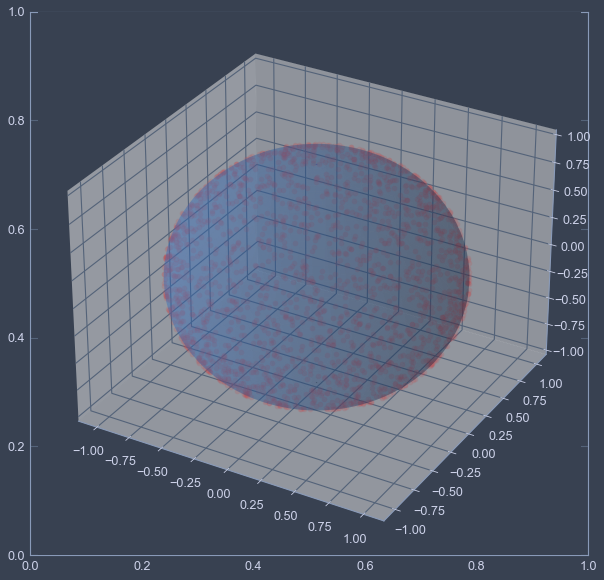

In [44]:
N=2000
pts=standard_normal(size=[N,3])          #get 3 N-length values
pts/=np.sqrt(np.sum(pts**2,axis=-1)[:,np.newaxis])   #normalize: v=v/|v|

fig,ax=plt.subplots(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot(pts[:,0],pts[:,1],pts[:,2],'ro', alpha=0.2, mec='none')

# For Visualization, make spherical surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x =  np.outer(np.cos(u), np.sin(v))
y =  np.outer(np.sin(u), np.sin(v))
z =  np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
collection=ax.plot_surface(x, y, z,alpha=0.25)

### Alternate method 2: Marsaglia's Method

**Choosing a point from the surface of sphere**, George Marsaglia 1972, *The Annals of Mathematical Statistics, vol. 43, No. 2, 645 - 646.*

From the paper:
>Generate $V_1$ and $V_2$ independent uniform on (-1,1) until $S= V_1^2+ V_2^2<1$ then form $(~2V_1(1-S)^{1/2}~,~2V_2(1-S)^{1/2}~,~1-2S~)$

Essentially we first generate uniform random samples on disk($\equiv$ inside a circle) and then transform them as prescribed to get points on a sphere. To generate the points on a disk, instead of rejection sampling as described, we will use the inverese transform sampling method described earlier. 

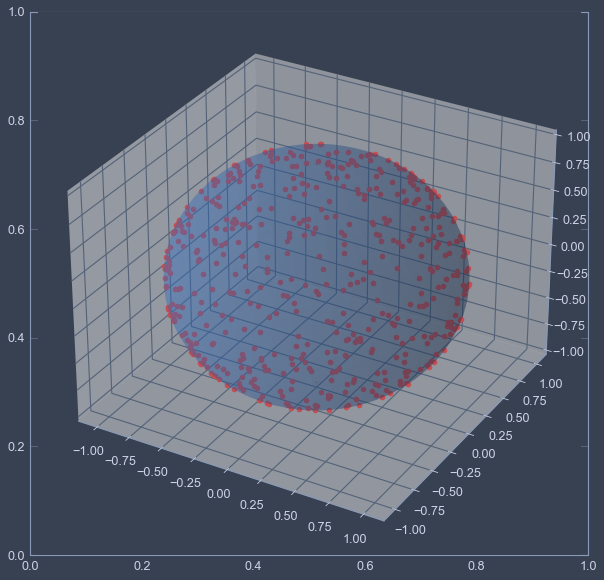

In [45]:
N=500
r     = np.sqrt(uniform(0.0,1.0,N))
t     = uniform(0,2*np.pi,N)

v1,v2 = r*np.cos(t),r*np.sin(t)
s     = v1**2+v2**2 
pts   = np.c_[2*v1*(np.sqrt(1-s)),2*v2*(np.sqrt(1-s)),1-2*s]

fig,ax=plt.subplots(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot(pts[:,0],pts[:,1],pts[:,2],'ro')

# For visualization, make spherical surface
u =  np.linspace(0, 2 * np.pi, 100)
v =  np.linspace(0, np.pi, 100)
x =  np.outer(np.cos(u), np.sin(v))
y =  np.outer(np.sin(u), np.sin(v))
z =  np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
collection=ax.plot_surface(x, y, z,alpha=0.25)

### Alternative method 3: Using quaternions
A [Quaternion](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation) is a set of 4 numbers represented as $(w,x,y,z)$ or $w+x~i+y~j+z~k$. This is an extension of complex numbers to 3D space. $i,j,k$ are imaginary numbers such that $i^2=j^2=k^2=ijk=-1$. The $i,j,k$ do not commute($ijk\neq ikj$). Quaternions can be used to rotate vectors in 3D space. A vector in 3D space can be rotated to a general position by rotating it about each of three axis in succession. This operation does not commute either. However, it turns out that any rotated position can be obtained by rotating the original vector by a particular angle about a particular axis. This is the axis-angle specification of a rotation. Quaternion is an alternative to the axis-angle method to represent rotations.

Choose three points  $u_1,u_2,u_3 \in [0,1]$ uniformly at random. A uniform, random quaternion is given by the simple expression $h = (\sqrt{1-u_1}\sin 2 \pi u_2, \sqrt{1-u_1}\cos 2 \pi u_2, \sqrt{u_1}\sin 2 \pi u_3, \sqrt{u_1}\cos 2 \pi u_3)$. (K. Shoemake. Uniform random rotations. D. Kirk, editor, Graphics Gems III, pages 124-132. Academic, New York, 1992)

In [46]:
u1 = uniform(0.0,1.0,N)
u2 = uniform(0.0,1.0,N)
u3 = uniform(0.0,1.0,N)
rnd_quats=np.c_[np.sqrt(1-u1)*np.sin(2*np.pi*u2), np.sqrt(1-u1)*np.cos(2*np.pi*u2),
                np.sqrt( u1 )*np.sin(2*np.pi*u3), np.sqrt( u1 )*np.cos(2*np.pi*u3) ]

Now that we have the random quaternions, we can generate the needed points by applying the quaternions to a reference position vector. I will choose $[1,0,0]$. To maintain the uniformity of the distribution each quaternion has to be applied to the same reference vector, which in this case is $[1,0,0]$. The actual rotation is done by multiplying the vector with a transformation matrix that is generated from the quaternion. The function below gives us the rotation matrix for a given quaternion.

In [47]:
def rotation_matrix_q(q):
    """Returns rotation matrix from quaternion.
    """
    q *= np.sqrt(2.0 / (q @ q))
    q = np.outer(q, q)
    return np.asarray([
           [1.0-q[2, 2]-q[3, 3],     q[1, 2]-q[3, 0],     q[1, 3]+q[2, 0]],
           [    q[1, 2]+q[3, 0], 1.0-q[1, 1]-q[3, 3],     q[2, 3]-q[1, 0]],
           [    q[1, 3]-q[2, 0],     q[2, 3]+q[1, 0], 1.0-q[1, 1]-q[2, 2]],])


Now we can rotate the the reference vector by applying the rotation matrix on the vector as shown below

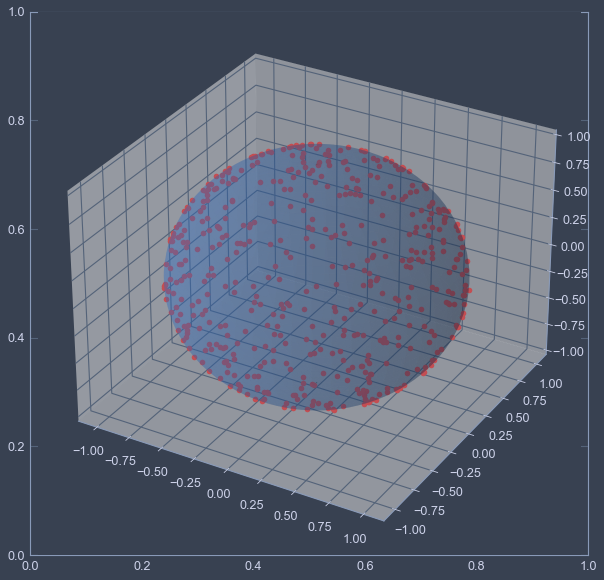

In [48]:
ref_v=np.asarray([1.0,0.0,0.0])
pts=np.empty([N,3])
for i,q in enumerate(rnd_quats):
    rot_mat = rotation_matrix_q(q)  
    pts[i]  = rot_mat.dot(ref_v.T).T
fig,ax=plt.subplots(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot(pts[:,0],pts[:,1],pts[:,2],'ro')

# For Visualization, make spherical surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x =  np.outer(np.cos(u), np.sin(v))
y =  np.outer(np.sin(u), np.sin(v))
z =  np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
collection=ax.plot_surface(x, y, z,alpha=0.25)

The following function calculates the rotation matrix from an axis-angle specification of a rotational transformation

In [49]:
def rotation_matrix_aa(axis,angle):
    """Returns matrix for rotation by 'angle' radians about 'axis' through the origin
    """
    axis/=np.sqrt(np.sum(axis**2))
    l,m,n = axis
    sina,cosa=np.sin(angle),np.cos(angle)
    return  np.asarray([
            [ l*l*(1-cosa)+  cosa , l*m*(1-cosa)+n*sina , l*n*(1-cosa)-m*sina ],
            [ m*l*(1-cosa)-n*sina , m*m*(1-cosa)+  cosa , m*n*(1-cosa)+l*sina ],
            [ n*l*(1-cosa)+m*sina , n*m*(1-cosa)-l*sina , n*n*(1-cosa)+  cosa ]])

This function is tested below. Say, we want to get the transformation matrix that rotates one vector `v1` to another vector `v2`. Two of the randomly generated vectors earlier are used for the demonstration (`pts[4] and pts[5]`). We rotate v1 to v2 and check if the rotation worked properly.

In [50]:
v1=pts[4]
v2=pts[5]

angle=np.arccos(np.dot(v1,v2)) # these are unit vectors so dot product is cosine of angle
axis=np.cross(v2,v1) # order matters

rot_mat=rotation_matrix_aa(axis,angle)

v1_rot=rot_mat.dot(v1.T).T
print(f"Are v1 and v2 equal? : {np.allclose(v1_rot,v2)}")

Are v1 and v2 equal? : True


# References
- [Christoph Gohlke -- Transformations.py](https://www.lfd.uci.edu/~gohlke/code/transformations.py.html)
- [SO -- Circle Uniform Sampling](https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly)
- [SO -- Sphere volume sampling](https://stackoverflow.com/a/5408843)
- [Math.SE -- surface of sphere](https://math.stackexchange.com/q/442418)
- [Wolfram Sphere Point Picking](http://mathworld.wolfram.com/SpherePointPicking.html)
- Osada et. al "Shape Distributions". ACM Transactions on Graphics, Vol. 21, No. 4, October 2002, Pages 807–832 <a name="osada"></a>